In [1]:


# ============================================================
# STEP 1: MOUNT GOOGLE DRIVE AND INSTALL LIBRARIES
# ============================================================

# Mount Google Drive to save models permanently
from google.colab import drive
drive.mount('/content/drive')

# Create project directory in Google Drive
import os
project_dir = '/content/drive/MyDrive/Mental_Health_Emotion_Project'
os.makedirs(project_dir, exist_ok=True)
print(f"Project directory: {project_dir}")

!pip install transformers datasets torch scikit-learn pandas numpy matplotlib seaborn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments
)
from transformers.trainer_callback import EarlyStoppingCallback
import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Mounted at /content/drive
Project directory: /content/drive/MyDrive/Mental_Health_Emotion_Project
Using device: cuda


In [2]:

# ============================================================
# STEP 2: LOAD GOEMOTIONS DATASET
# ============================================================

print("\n Loading GoEmotions Dataset...")
dataset = load_dataset("google-research-datasets/go_emotions", "simplified")

print("\nDataset Structure:")
print(dataset)




 Loading GoEmotions Dataset...


README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]


Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})


In [3]:
# ============================================================
# STEP 3: DATA EXPLORATION AND PREPROCESSING
# ============================================================

print("\n Exploring the Dataset...")

# Convert to pandas for easier exploration
train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

print(f"\nTraining samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

print("\nSample data:")
print(train_df.head())

print("\n Dataset Info:")
print(train_df.info())

# Check for missing values
print("\nMissing Values:")
print(train_df.isnull().sum())

# Get emotion labels
emotion_labels = dataset['train'].features['labels'].feature.names
print(f"\n Emotion Categories ({len(emotion_labels)} emotions):")
for i, label in enumerate(emotion_labels):
    print(f"{i}: {label}")


 Exploring the Dataset...

Training samples: 43410
Validation samples: 5426
Test samples: 5427

Sample data:
                                                text labels       id
0  My favourite food is anything I didn't have to...   [27]  eebbqej
1  Now if he does off himself, everyone will thin...   [27]  ed00q6i
2                     WHY THE FUCK IS BAYLESS ISOING    [2]  eezlygj
3                        To make her feel threatened   [14]  ed7ypvh
4                             Dirty Southern Wankers    [3]  ed0bdzj

 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    43410 non-null  object
 1   labels  43410 non-null  object
 2   id      43410 non-null  object
dtypes: object(3)
memory usage: 1017.6+ KB
None

Missing Values:
text      0
labels    0
id        0
dtype: int64

 Emotion Categories (28 emotions):
0: admiration
1: amuse

In [4]:
# ============================================================
# STEP 4: DATA CLEANING AND PREPROCESSING
# ============================================================

print("\nCleaning and Preprocessing Data...")

def clean_text(text):
    """Clean and preprocess text"""
    if pd.isna(text):
        return ""
    # Remove extra whitespaces
    text = ' '.join(text.split())
    # Remove special characters but keep basic punctuation
    text = text.strip()
    return text

# Apply cleaning
train_df['text'] = train_df['text'].apply(clean_text)
val_df['text'] = val_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

# Remove empty texts
train_df = train_df[train_df['text'].str.len() > 0]
val_df = val_df[val_df['text'].str.len() > 0]
test_df = test_df[test_df['text'].str.len() > 0]

print(f"After cleaning - Training samples: {len(train_df)}")

# Handle multi-label by taking the first label for simplicity
train_df['label'] = train_df['labels'].apply(lambda x: x[0] if len(x) > 0 else 0)
val_df['label'] = val_df['labels'].apply(lambda x: x[0] if len(x) > 0 else 0)
test_df['label'] = test_df['labels'].apply(lambda x: x[0] if len(x) > 0 else 0)




Cleaning and Preprocessing Data...
After cleaning - Training samples: 43410



 Visualizing Emotion Distribution...


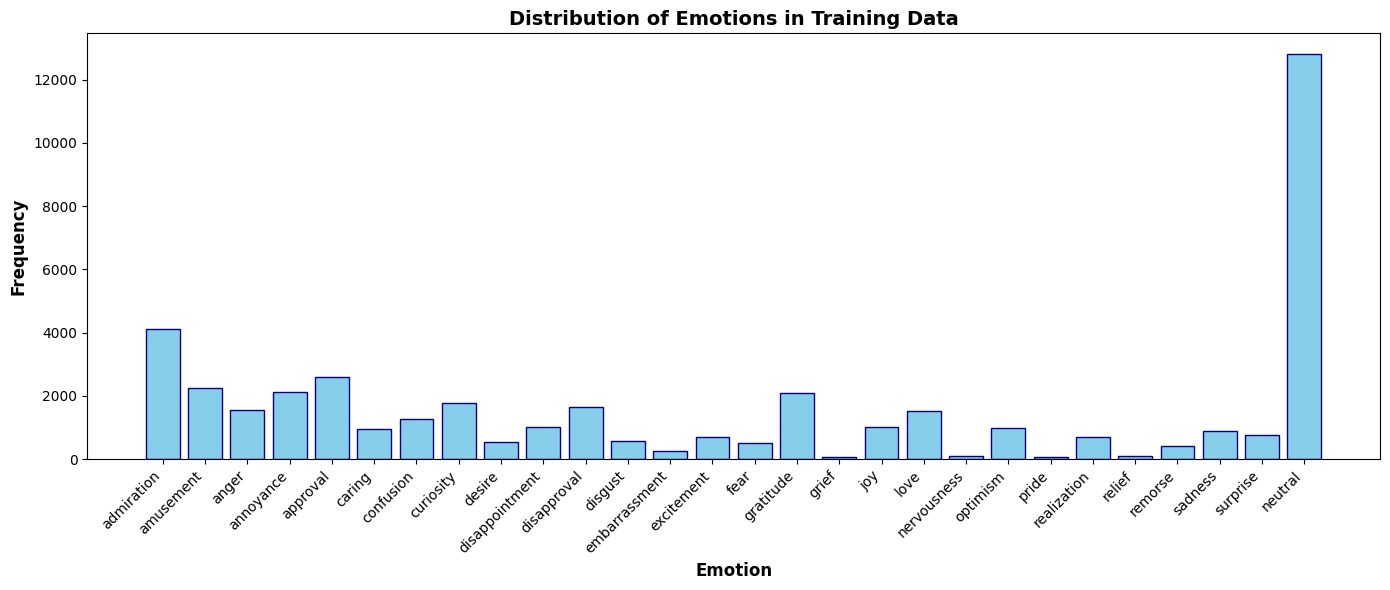

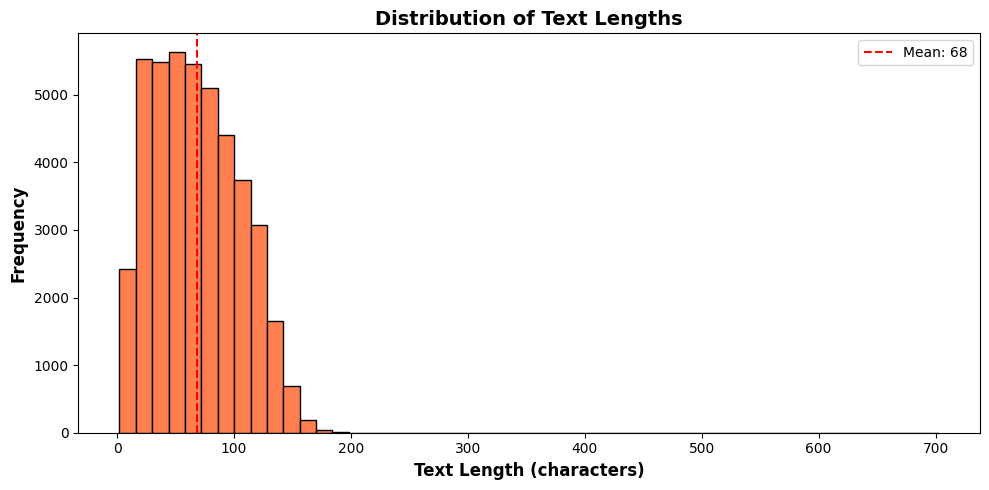

In [5]:
# ============================================================
# STEP 5: VISUALIZE EMOTION DISTRIBUTION
# ============================================================

print("\n Visualizing Emotion Distribution...")

plt.figure(figsize=(14, 6))
emotion_counts = train_df['label'].value_counts().sort_index()
emotion_names = [emotion_labels[i] for i in emotion_counts.index]

plt.bar(range(len(emotion_counts)), emotion_counts.values, color='skyblue', edgecolor='navy')
plt.xlabel('Emotion', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Distribution of Emotions in Training Data', fontsize=14, fontweight='bold')
plt.xticks(range(len(emotion_counts)), emotion_names, rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Text length distribution
plt.figure(figsize=(10, 5))
train_df['text_length'] = train_df['text'].str.len()
plt.hist(train_df['text_length'], bins=50, color='coral', edgecolor='black')
plt.xlabel('Text Length (characters)', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Distribution of Text Lengths', fontsize=14, fontweight='bold')
plt.axvline(train_df['text_length'].mean(), color='red', linestyle='--', label=f'Mean: {train_df["text_length"].mean():.0f}')
plt.legend()
plt.tight_layout()
plt.show()



In [6]:
# ============================================================
# STEP 6: PREPARE DATA FOR ROBERTA MODEL
# ============================================================

print("\n Preparing data for RoBERTa model...")

# Check if there's a checkpoint to resume from
checkpoint_dir = f'{project_dir}/results'
resume_from_checkpoint = None
if os.path.exists(checkpoint_dir):
    checkpoints = [d for d in os.listdir(checkpoint_dir) if d.startswith('checkpoint-')]
    if checkpoints:
        # Sort by checkpoint number and get the latest
        checkpoints.sort(key=lambda x: int(x.split('-')[1]))
        resume_from_checkpoint = os.path.join(checkpoint_dir, checkpoints[-1])
        print(f"Found checkpoint: {checkpoints[-1]}")
        print(f" Will resume training from: {resume_from_checkpoint}")

# USING FULL DATASET - This will take longer but give better results
# For faster testing, you can uncomment the sampling lines below:
# train_sample = train_df.sample(n=min(10000, len(train_df)), random_state=42)
# val_sample = val_df.sample(n=min(2000, len(val_df)), random_state=42)

# Using full dataset
train_sample = train_df
val_sample = val_df

print(f"Training on {len(train_sample)} samples (~43,000)")
print(f"Validating on {len(val_sample)} samples (~5,400)")

# Initialize tokenizer
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)

# Tokenize data
def tokenize_function(texts, labels):
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,
        padding=True,
        max_length=128,  # Reduced for faster training
        return_tensors='pt'
    )
    encodings['labels'] = torch.tensor(labels.tolist())
    return encodings

print("Tokenizing training data...")
train_encodings = tokenize_function(train_sample['text'], train_sample['label'])

print("Tokenizing validation data...")
val_encodings = tokenize_function(val_sample['text'], val_sample['label'])

# Create torch datasets
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings['input_ids'])

train_dataset = EmotionDataset(train_encodings)
val_dataset = EmotionDataset(val_encodings)




 Preparing data for RoBERTa model...
Training on 43410 samples (~43,000)
Validating on 5426 samples (~5,400)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Tokenizing training data...
Tokenizing validation data...


In [8]:
# ============================================================
# STEP 7: INITIALIZE AND TRAIN ROBERTA MODEL
# ============================================================

print("\n Initializing RoBERTa model...")

num_labels = len(emotion_labels)
model = RobertaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
).to(device)

# Training arguments optimized for GTX GPU
training_args = TrainingArguments(
    output_dir=f'{project_dir}/results',  # Save to Google Drive
    num_train_epochs=3,  # You can increase this for better results
    per_device_train_batch_size=16,  # Adjust based on your GPU memory
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=f'{project_dir}/logs',  # Save logs to Google Drive
    logging_steps=100,
    eval_strategy="steps",  # Updated parameter name
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=2,
    # fp16=torch.cuda.is_available(),  # Mixed precision for faster training
    report_to="none"
)

# Ensure the output directory exists
os.makedirs(training_args.output_dir, exist_ok=True)


# Define metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    return {'accuracy': accuracy}

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
print("\n Training RoBERTa model...")
print("This may take 1.5-2.5 hours for full dataset...")
print(" Checkpoints will be saved every 500 steps to Google Drive")

# Resume from checkpoint if available
# Removing resume functionality to avoid fp16/CPU conflict
# if resume_from_checkpoint:
#     trainer.train(resume_from_checkpoint=resume_from_checkpoint)
# else:
trainer.train()

print("\nTraining completed!")


 Initializing RoBERTa model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Training RoBERTa model...
This may take 1.5-2.5 hours for full dataset...
 Checkpoints will be saved every 500 steps to Google Drive


Step,Training Loss,Validation Loss,Accuracy
500,1.878800,1.816479,0.473277


KeyboardInterrupt: 

In [ ]:
# ============================================================
# STEP 8: EVALUATE THE MODEL
# ============================================================

print("\n Evaluating the model...")

# Evaluate on test set
test_encodings = tokenize_function(test_df['text'], test_df['label'])
test_dataset = EmotionDataset(test_encodings)

predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = test_df['label'].values

# Calculate metrics
accuracy = accuracy_score(true_labels, pred_labels)
print(f"\n Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Classification report
print("\n Classification Report:")
print(classification_report(
    true_labels,
    pred_labels,
    target_names=emotion_labels,
    zero_division=0
))

# Confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('True', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [ ]:
# ============================================================
# STEP 9: SAVE THE MODEL TO GOOGLE DRIVE
# ============================================================

print("\nSaving the final model to Google Drive...")
model_save_path = f'{project_dir}/emotion_roberta_model'
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f" Model saved to: {model_save_path}")
print("You can now access this model anytime, even after Colab disconnects!")

# Save emotion labels for later use
import json
labels_path = f'{project_dir}/emotion_labels.json'
with open(labels_path, 'w') as f:
    json.dump(emotion_labels, f)
print(f" Emotion labels saved to: {labels_path}")



In [ ]:
# ============================================================
# STEP 10: LOAD MODEL FROM GOOGLE DRIVE (FOR RESUMING)
# ============================================================

def load_saved_model():
    """
    Load the saved model from Google Drive
    Use this function when you want to resume or use the trained model
    """
    model_path = f'{project_dir}/emotion_roberta_model'

    # Check if model exists
    if not os.path.exists(model_path):
        print(" No saved model found. Please train the model first.")
        return None, None, None

    print(f"\nLoading model from: {model_path}")

    # Load model and tokenizer
    loaded_model = RobertaForSequenceClassification.from_pretrained(model_path).to(device)
    loaded_tokenizer = RobertaTokenizer.from_pretrained(model_path)

    # Load emotion labels
    labels_path = f'{project_dir}/emotion_labels.json'
    with open(labels_path, 'r') as f:
        loaded_labels = json.load(f)

    print("Model loaded successfully!")
    return loaded_model, loaded_tokenizer, loaded_labels

# Uncomment the lines below if you want to load a previously saved model
# instead of training from scratch:
# model, tokenizer, emotion_labels = load_saved_model()
# if model is None:
#     print("Training new model...")
# else:
#     print("Using previously trained model!")



In [ ]:
# ============================================================
# STEP 11: EMOTION PREDICTION FUNCTION
# ============================================================

def predict_emotion(text):

    # Clean the text
    text = clean_text(text)

    # Tokenize
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Get top 3 emotions
    top_probs, top_indices = torch.topk(predictions[0], k=3)

    results = []
    for prob, idx in zip(top_probs, top_indices):
        results.append({
            'emotion': emotion_labels[idx.item()],
            'confidence': prob.item()
        })

    return results



In [ ]:
# ============================================================
# STEP 12: INTERACTIVE EMOTION DETECTION
# ============================================================

print("\n" + "="*60)
print(" EMOTION DETECTION SYSTEM READY!")
print("="*60)

# Test with some examples
test_texts = [
    "I'm so happy and excited about my new job!",
    "I feel really sad and lonely today.",
    "This is making me so angry and frustrated!",
    "I'm terrified of what might happen tomorrow.",
    "I'm grateful for all the support I've received.",
    "I can't believe this is happening, I'm shocked!"
]

print("\nTesting with sample texts:\n")
for text in test_texts:
    print(f"Text: '{text}'")
    results = predict_emotion(text)
    print(f" Primary Emotion: {results[0]['emotion']} (Confidence: {results[0]['confidence']:.2%})")
    print(f"   Top 3 emotions:")
    for i, result in enumerate(results, 1):
        print(f"   {i}. {result['emotion']}: {result['confidence']:.2%}")
    print()



In [ ]:
# ============================================================
# STEP 13: EMOTION PREDICTION
# ============================================================

print("\n" + "="*60)

print("="*60)

def analyze_my_emotion():
    while True:
        user_input = input("\nEnter your text (or 'quit' to exit): ").strip()

        if user_input.lower() in ['quit', 'exit', 'q']:
            print("Thank you for using the Emotion Detection System! ")
            break

        if not user_input:
            print("Please enter some text.")
            continue

        print(f"\n Analyzing: '{user_input}'")
        results = predict_emotion(user_input)

        print(f"\n{'='*50}")
        print(f" DETECTED EMOTION: {results[0]['emotion'].upper()}")
        print(f"{'='*50}")
        print(f"\nConfidence: {results[0]['confidence']:.2%}")
        print(f"\n All emotion probabilities:")
        for i, result in enumerate(results, 1):
            bar = '█' * int(result['confidence'] * 50)
            print(f"{i}. {result['emotion']:15} {bar} {result['confidence']:.2%}")
        print()

# Run the interactive analyzer
analyze_my_emotion()



In [ ]:
import shutil
from google.colab import files

# Path to your model in Google Drive
model_path = '/content/drive/MyDrive/Mental_Health_Emotion_Project/emotion_roberta_model'

# Create a zip file of your model
shutil.make_archive('emotion_model', 'zip', model_path)

# Download the zip file
files.download('emotion_model.zip')

# Also download emotion_labels.json
labels_path = '/content/drive/MyDrive/Mental_Health_Emotion_Project/emotion_labels.json'
files.download(labels_path)